In [138]:
# delete unused packages
import scipy as sp, numpy as np
from scipy import stats
import pandas as pd
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import r2_score
from numpy.polynomial.polynomial import polyfit
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from Levenshtein import distance
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Importing Data

In [139]:
X = np.array(pd.read_csv('./MS_Initial_Data.csv', header=0))
Y = np.array(pd.read_csv('./Ydata.csv', header=0))
treatments_axl = np.array(pd.read_csv('./MS_Initial_Data.csv', header=None))[0,2:]
treatments_cv = np.delete(treatments_axl,[3,7,8,9])

peptide_phosphosite = X[:,0]
protein_description = X[:,1]
PC9 = X[:,2]
Erl = X[:,3]
R428 = X[:,4]
Erl_R428 = X[:,5]
Erl_HGF = X[:,6]
Erl_FGF = X[:,7]
Erl_IGF = X[:,8]
KO_Erl = X[:,9]
KO_R428 = X[:,10]
KO_Erl_R428 = X[:,11]

# for AXL expression
X_axl = np.concatenate([PC9,Erl,R428,Erl_R428,Erl_HGF,Erl_FGF,Erl_IGF,KO_Erl,KO_R428,KO_Erl_R428])
X_axl = np.reshape(X_axl,(10,300))
Y_axl = Y[:,3]

#for now- redo CSV later when have finalized Y data
Y_axl = Y_axl[:10]

# for CV
X_cv = np.concatenate([PC9,Erl,R428,Erl_HGF,Erl_FGF,Erl_IGF])
X_cv = np.reshape(X_cv,(6,300))
Y_cv = Y[:,2]

# temp- change with final csv
del_cv = np.arange(7,36)
Y_cv = np.delete(Y_cv,[del_cv])
Y_cv = np.delete(Y_cv,3)

## Preprocessing Data

Z-score Y vectors for AXL Expression and Cell Viability and their corresponding X matrices by treatment.

In [4]:
Y_axl_z = sp.stats.zscore(Y_axl)
Y_cv_z = sp.stats.zscore(Y_cv)

def zscore_columns(matrix):
    for a in range(matrix.shape[1]):
        column = []
        column = matrix[:,a]
        column_mean = np.mean(column)
        column_std = np.std(column)
        matrix[:,a] = np.asmatrix([(column-column_mean)/column_std])
    return matrix

X_axl_z = zscore_columns(X_axl)
X_cv_z = zscore_columns(X_cv)

## Determining Number of Components

Below, R2Y, is plotted for both AXL Expression and Cell Viability. Note that R2Y is maximized at 9 components for AXL Expression and 5 components for Cell Viability. However, 3 components were picked for both models, as increases in R2Y become less than 0.002 after this point. **Revise for CV input/Q2Y calculation**

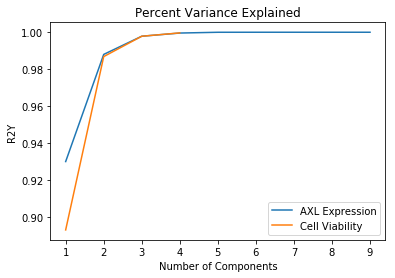

In [5]:
def plot_number_comps(X_z,Y_z,max_comps,sublabel):
    R2Ys = []
    components = []
    for b in range(1,max_comps):
        plsr = PLSRegression(n_components = b)
        X_scores, Y_scores = plsr.fit_transform(X_z,Y_z)
        R2Y = plsr.score(X_z,Y_z)
        R2Ys.append(R2Y)
        components.append(b)
    return plt.plot(components,R2Ys,label=sublabel)

plt.title('Percent Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('R2Y')
plot_number_comps(X_axl_z,Y_axl_z,10,'AXL Expression')
plot_number_comps(X_cv_z,Y_cv_z,5,'Cell Viability')
plt.legend()
plt.show()

### Leave-One-Out-CV 

In [6]:
def LOOCV(Xz, Yz):
    loo = LeaveOneOut()
    Predictions = []
    for train_index, test_index in loo.split(Xz):
        Xtrain, Xtest = Xz[train_index], Xz[test_index] 
        Ytrain, Ytest = Yz[train_index], Yz[test_index]
        pls = PLSRegression(n_components = 3)
        pls.fit(Xtrain, Ytrain)
        Y_pred = float(pls.predict(Xtest))
        Predictions.append(Y_pred)
    R2Y = r2_score(Yz, Predictions)
    return R2Y, Predictions

The model fitness to predict AXL concentration is:  0.853719442002
The model fitness to predict Cell Viability is:  -0.514233601124


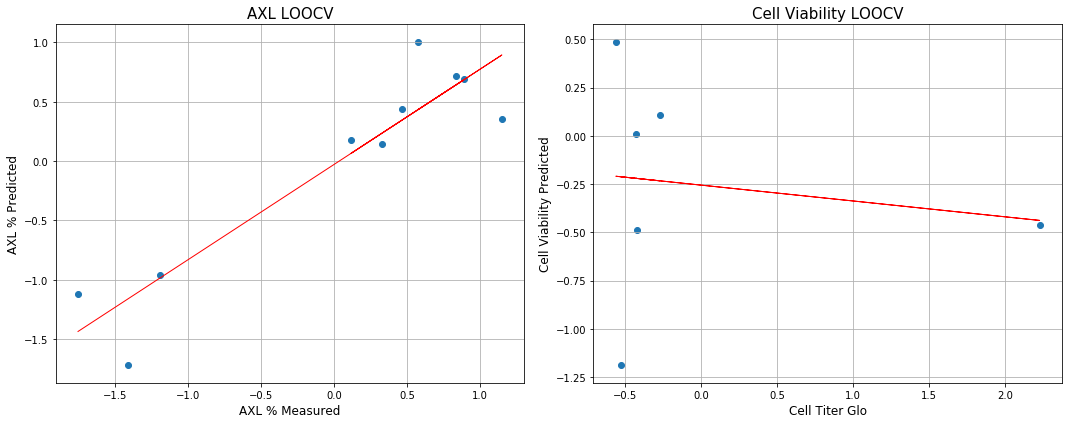

[-0.27592777277045005 -0.5634168782812395 2.2266227659018063
 -0.4310405394530187 -0.4252735093051978 -0.5309640660919005]


In [7]:
Axl_R2Y, AxlPredictions = LOOCV(X_axl_z,Y_axl_z)
CV_R2Y, CV_Predictions = LOOCV(X_cv_z,Y_cv_z)
print("The model fitness to predict AXL concentration is: ", Axl_R2Y)
print("The model fitness to predict Cell Viability is: ", CV_R2Y)
    
#Plotting AXL CV
fig = plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1,2,1)
ax1.scatter(Y_axl_z, AxlPredictions)
ax1.grid()
ax1.set_title("AXL LOOCV", fontsize = "15")
ax1.set_ylabel("AXL % Predicted",fontsize = "12")
ax1.set_xlabel("AXL % Measured",fontsize = "12")
Y_axl_z_float = np.array(Y_axl_z, dtype = float)
b, m = polyfit(Y_axl_z_float, AxlPredictions, 1)
plt.plot(Y_axl_z_float, b + m * Y_axl_z_float, '-', color = "r", linewidth = 1)
    
#Plotting Cell Viability CV
ax2 = plt.subplot(1,2,2)
ax2.scatter(Y_cv_z, CV_Predictions)
ax2.grid()
ax2.set_title("Cell Viability LOOCV", fontsize = "15")
ax2.set_ylabel("Cell Viability Predicted",fontsize = "12")
ax2.set_xlabel("Cell Titer Glo",fontsize = "12")
Y_cv_z_float = np.array(Y_cv_z, dtype = float)
b, m = polyfit(Y_cv_z_float, CV_Predictions, 1)
plt.plot(Y_cv_z_float, b + m * Y_cv_z_float, '-', color = "r", linewidth = 1)
fig.tight_layout()
plt.show()

print(Y_cv_z) #Use LASSO?

## Running PLSR for Each Y

PLSR with three components is run for both AXL Expression and Cell Viability, and the corresponding scores and loadings data is organized.

In [8]:
plsr_axl = PLSRegression(n_components = 3)
X_scores_axl, Y_scores_axl = plsr_axl.fit_transform(X_axl_z,Y_axl_z)
PC1_scores_axl, PC2_scores_axl = X_scores_axl[:,0], X_scores_axl[:,1]
PC1_xload_axl, PC2_xload_axl = plsr_axl.x_loadings_[:,0], plsr_axl.x_loadings_[:,1]
PC1_yload_axl, PC2_yload_axl = plsr_axl.y_loadings_[:,0], plsr_axl.y_loadings_[:,1]

plsr_cv = PLSRegression(n_components = 3)
X_scores_cv, Y_scores_cv = plsr_cv.fit_transform(X_cv_z,Y_cv_z)
PC1_scores_cv, PC2_scores_cv = X_scores_cv[:,0], X_scores_cv[:,1]
PC1_xload_cv, PC2_xload_cv = plsr_cv.x_loadings_[:,0], plsr_cv.x_loadings_[:,1]
PC1_yload_cv, PC2_yload_cv = plsr_cv.y_loadings_[:,0], plsr_cv.y_loadings_[:,1]

## Clustering by Sequence Similarity

The sequences are sliced to only the three **amino acids** on each side of **phosphorylation site**. Then, a **PAM matrix** is constructed using Levenshtein distances. From this matrix, k-means is used to form four clusters.

In [9]:
def surrounding_three(sequences):
    bracket3 = []
    for g in range(len(sequences)):
        for h in range(len(sequences[g])):
            if (peptide_phosphosite[g])[h] == 'y':
                surround = ''
                for i in range(-3,4):
                    surround = surround + (peptide_phosphosite[g][h+i])
        bracket3.append(surround)
    return bracket3

def sequence_clustering(sequences,number_of_clusters):
    distances = []
    for c in range(len(sequences)):
        rel_dist = []
        for d in range(len(sequences)):
            rel_dist.append(distance(sequences[c],sequences[d]))
        distances.append(rel_dist)
    kmeans = KMeans(n_clusters=number_of_clusters)
    kmeans.fit(distances)
    clusters = kmeans.fit_predict(distances)
    # Note that this may be amended for more than four clusters
    cluster0, cluster1, cluster2, cluster3 = [], [], [], []
    for f in range(len(clusters)):
        if clusters[f] == 0:
            cluster0.append(f)
        if clusters[f] == 1:
            cluster1.append(f)
        if clusters[f] == 2:
            cluster2.append(f)
        if clusters[f] == 3:
            cluster3.append(f)
    return cluster0,cluster1,cluster2,cluster3

peptide_phosphosite_3 = surrounding_three(peptide_phosphosite)
cluster0_axl, cluster1_axl, cluster2_axl, cluster3_axl = sequence_clustering(peptide_phosphosite_3, 4)

## Results: AXL Expression

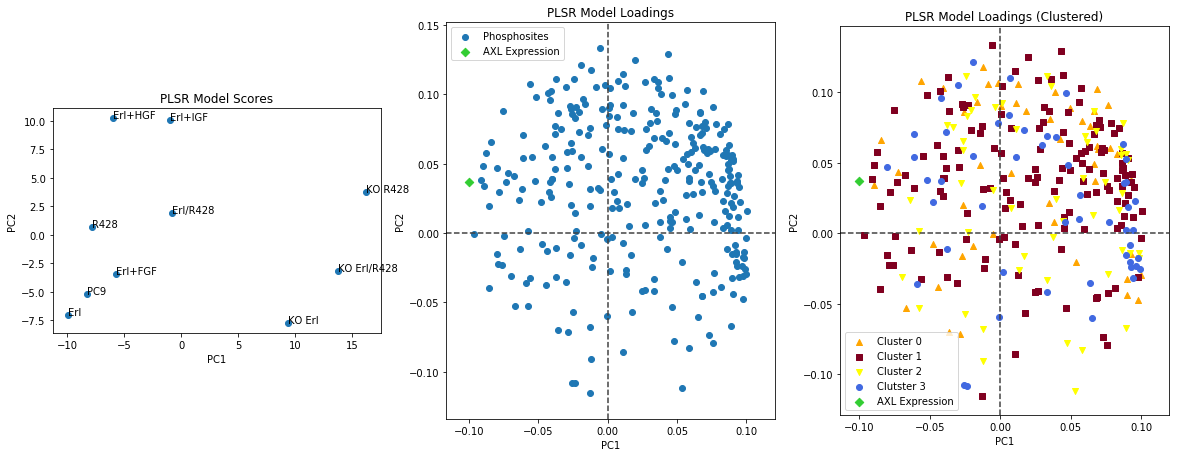

In [10]:
fig, axs = plt.subplots(1, 3,figsize=(20,10))
axs[0].scatter(PC1_scores_axl,PC2_scores_axl)
for j, txt in enumerate(treatments_axl):
    axs[0].annotate(txt, (PC1_scores_axl[j], PC2_scores_axl[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_aspect('equal')
axs[1].scatter(PC1_xload_axl,PC2_xload_axl, label='Phosphosites')
axs[1].scatter(PC1_yload_axl,PC2_yload_axl, color='#32CD32', marker='D', label='AXL Expression')
axs[1].set_title('PLSR Model Loadings')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].set_aspect('equal')
axs[1].legend()
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[2].scatter(PC1_xload_axl[cluster0_axl], PC2_xload_axl[cluster0_axl], color='#FFA500', marker='^', label='Cluster 0')
axs[2].scatter(PC1_xload_axl[cluster1_axl], PC2_xload_axl[cluster1_axl], color='#800020', marker='s', label='Cluster 1')
axs[2].scatter(PC1_xload_axl[cluster2_axl], PC2_xload_axl[cluster2_axl], color='#FFFF00', marker='v', label='Cluster 2')
axs[2].scatter(PC1_xload_axl[cluster3_axl], PC2_xload_axl[cluster3_axl], color='#4169E1', label='Clutster 3')
axs[2].scatter(PC1_yload_axl, PC2_yload_axl, color='#32CD32', marker='D', label='AXL Expression')
axs[2].legend()
axs[2].set_title('PLSR Model Loadings (Clustered)')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')
axs[2].set_aspect('equal')
axs[2].axhline(y=0, color='0.25', linestyle='--')
axs[2].axvline(x=0, color='0.25', linestyle='--')
plt.show()

## Results: Cell Viability

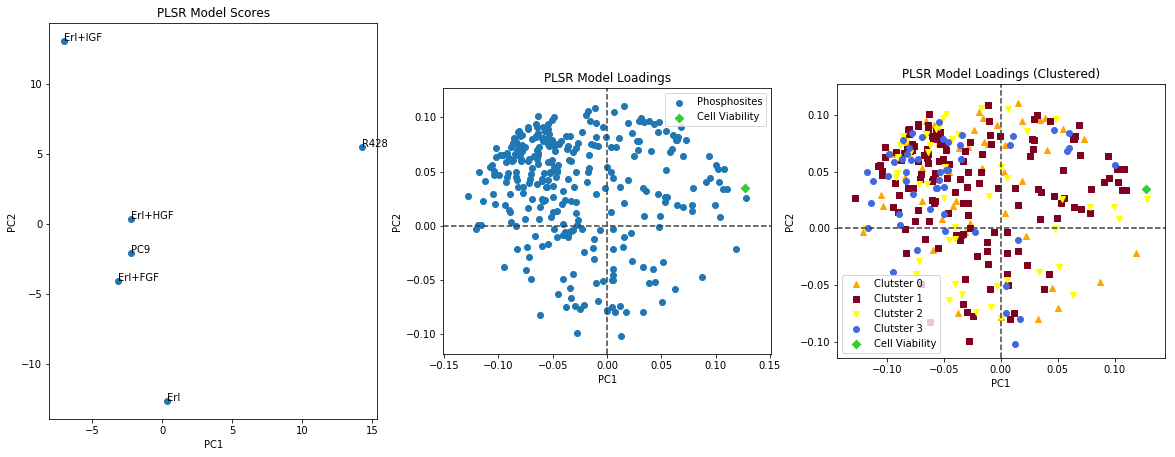

In [11]:
fig, axs = plt.subplots(1, 3,figsize=(20,10))
axs[0].scatter(PC1_scores_cv,PC2_scores_cv)
for k, txt_ in enumerate(treatments_cv):
    axs[0].annotate(txt_, (PC1_scores_cv[k], PC2_scores_cv[k]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_aspect('equal')
axs[1].scatter(PC1_xload_cv,PC2_xload_cv, label='Phosphosites')
axs[1].scatter(PC1_yload_cv,PC2_yload_cv, color='#32CD32', marker='D', label='Cell Viability')
axs[1].set_title('PLSR Model Loadings')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].set_aspect('equal')
axs[1].legend()
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[2].scatter(PC1_xload_cv[cluster0_axl], PC2_xload_cv[cluster0_axl], color='#FFA500', marker='^', label='Clutster 0')
axs[2].scatter(PC1_xload_cv[cluster1_axl], PC2_xload_cv[cluster1_axl], color='#800020', marker='s', label='Clutster 1')
axs[2].scatter(PC1_xload_cv[cluster2_axl], PC2_xload_cv[cluster2_axl], color='#FFFF00', marker='v', label='Clutster 2')
axs[2].scatter(PC1_xload_cv[cluster3_axl], PC2_xload_cv[cluster3_axl], color='#4169E1', label='Clutster 3')
axs[2].scatter(PC1_yload_cv, PC2_yload_cv, color='#32CD32', marker='D', label='Cell Viability')
axs[2].legend()
axs[2].set_title('PLSR Model Loadings (Clustered)')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')
axs[2].set_aspect('equal')
axs[2].axhline(y=0, color='0.25', linestyle='--')
axs[2].axvline(x=0, color='0.25', linestyle='--')
plt.show()

## LASSO; Regression alternative for Cell Viability predictions

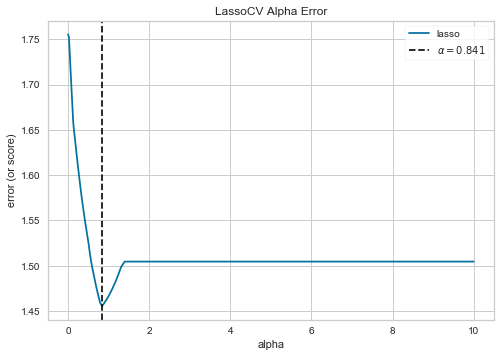

In [105]:
from yellowbrick.regressor import AlphaSelection

# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 400)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)

visualizer.fit(X_cv_z, Y_cv_z)
g = visualizer.poof()

In [143]:
clf = linear_model.Lasso(alpha=0.841)
fit = clf.fit(X_cv_z, Y_cv_z)
coef = clf.coef_
print("Variable Idx", "Coefficient")
for i, value in enumerate(coef):
    print(i+1, "\t", value, "\n")
print()
score = clf.score(X_cv_z, Y_cv_z)
print("Coefficient of determination R^2 of the predictions: ", score)

Variable Idx Coefficient
1 	 -0.0 

2 	 -0.0 

3 	 -0.0 

4 	 -0.0 

5 	 -0.0 

6 	 -0.0 

7 	 -0.0 

8 	 -0.0 

9 	 -0.0 

10 	 -0.0 

11 	 -0.0 

12 	 -0.0 

13 	 -0.0 

14 	 -0.0 

15 	 -0.0 

16 	 -0.0 

17 	 -0.0 

18 	 -0.0 

19 	 -0.0 

20 	 -0.0 

21 	 -0.0 

22 	 -0.0 

23 	 -0.0 

24 	 -0.0 

25 	 0.0 

26 	 -0.0 

27 	 0.0 

28 	 -0.0 

29 	 -0.0 

30 	 -0.0 

31 	 -0.0 

32 	 -0.0 

33 	 -0.0 

34 	 -0.0 

35 	 -0.0 

36 	 -0.0 

37 	 -0.0 

38 	 -0.0 

39 	 -0.0 

40 	 -0.0 

41 	 -0.0 

42 	 -0.0 

43 	 -0.0 

44 	 0.0 

45 	 0.0 

46 	 -0.0 

47 	 -0.0 

48 	 -0.0 

49 	 -0.0 

50 	 -0.0 

51 	 -0.0 

52 	 0.0 

53 	 -0.0 

54 	 -0.0 

55 	 -0.0 

56 	 -0.0 

57 	 -0.0 

58 	 -0.0 

59 	 -0.0 

60 	 -0.0 

61 	 -0.0 

62 	 -0.0 

63 	 -0.0 

64 	 -0.0 

65 	 -0.0 

66 	 -0.0 

67 	 -0.0 

68 	 -0.0 

69 	 -0.0 

70 	 -0.0 

71 	 0.0 

72 	 -0.0 

73 	 0.0 

74 	 -0.0 

75 	 -0.0 

76 	 -0.0 

77 	 -0.0 

78 	 -0.0 

79 	 -0.0 

80 	 -0.0 

81 	 -0.0 

82 	 -0.0 

83 	 -0

## LASSO CV

subsets of the data:
[fold 0] alpha: 0.01262, score: 0.00000
[fold 1] alpha: 1.00000, score: 0.00000
[fold 2] alpha: 0.01262, score: 0.00000
[fold 3] alpha: 0.14175, score: 0.00000
[fold 4] alpha: 1.00000, score: 0.00000
[fold 5] alpha: 0.83022, score: 0.00000


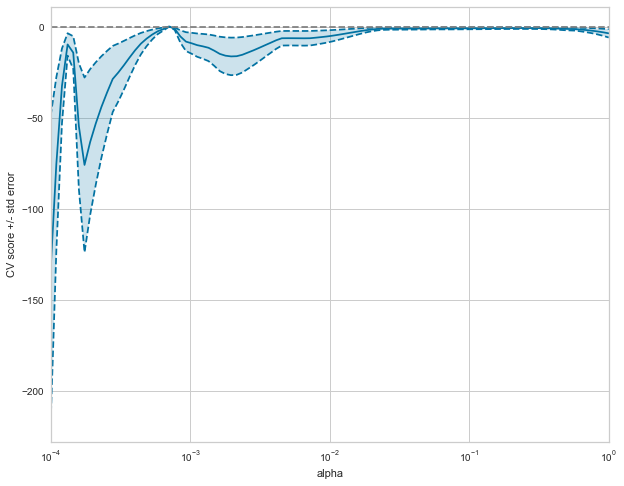

In [142]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


lasso = Lasso(random_state=0)
alphas = np.logspace(-4, 0, 100)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X_cv_z, Y_cv_z)
scores = clf.cv_results_['mean_test_score'] 
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(10, 8);
plt.semilogx(alphas, scores);

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--');
plt.semilogx(alphas, scores - std_error, 'b--');

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2);

plt.ylabel('CV score +/- std error');
plt.xlabel('alpha');
plt.axhline(np.max(scores), linestyle='--', color='.5');
plt.xlim([alphas[0], alphas[-1]]);

lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=0)
k_fold = KFold(6)

print("subsets of the data:")
for k, (train, test) in enumerate(k_fold.split(X_cv_z, Y_cv_z)):
    lasso_cv.fit(X_cv_z[train], Y_cv_z[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".format(k, lasso_cv.alpha_, lasso_cv.score(X_cv_z[test], Y_cv_z[test])))

plt.show();